# Code Credit
Modified from https://github.com/vntkumar8/musical-instrument-classification under Open Source license.

## Summary of changes
Hyperparameter tuning, increasing classification labels, isolate SVC (best performing), add exports, and more.

In [2]:
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import pandas as pd
import numpy as np
from statistics import stdev
import IPython.display as ipd
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import itertools

In [3]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv
import tqdm

# Preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import cross_val_score

# Creating features from audio files

In [5]:
header = 'filename rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [6]:
file = open('../dataset/data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

In [8]:
Instruments = 'cel cla flu gac gel org pia sax tru vio voi'.split()
for i in Instruments:
    for filename in tqdm.tqdm(os.listdir(os.path.join('../dataset/IRMAS-TrainingData', f'{i}'))):
        songname = os.path.join('../dataset/IRMAS-TrainingData', i, filename)
        y, sr = librosa.load(songname, sr =44100)
        rms = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {i}'
        file = open('../dataset/data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [10]:
df = pd.read_csv('../dataset/data.csv')
df.head()

,filename,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,008__[cel][nod][cla]0058__1.wav,0.005622,1273.967038,1974.181216,2121.477777,0.033642,-548.299316,189.765564,-21.121988,15.259335,...,-0.564254,1.159621,-0.287216,-1.051063,2.558362,7.008935,9.611934,6.723992,2.892501,cel
1,008__[cel][nod][cla]0058__2.wav,0.009950,1369.496771,1985.402338,2307.544605,0.035053,-492.253021,180.435959,-30.720634,16.488262,...,-3.774964,-4.976338,-5.985732,-12.421291,-7.708522,-5.190786,0.197547,10.872709,21.063335,cel
2,008__[cel][nod][cla]0058__3.wav,0.015884,1515.558971,2010.045759,2452.374103,0.041344,-445.286987,170.886612,-36.930515,13.339684,...,-1.129981,0.303812,2.144062,3.028069,4.692125,1.315577,-4.312213,-6.950765,-1.198687,cel
3,012__[cel][nod][cla]0043__1.wav,0.017558,1764.444040,2402.842740,3208.613545,0.042100,-370.563354,182.482651,-35.701279,31.877964,...,-3.459521,-4.016848,-2.542539,2.515918,3.337309,-1.405248,-2.197753,0.097689,-1.399735,cel
4,012__[cel][nod][cla]0043__2.wav,0.020022,1949.381979,2529.054589,3562.539590,0.046834,-359.077881,171.018555,-36.208290,24.581499,...,-2.380702,-7.200488,-5.400430,2.223381,5.510553,1.154641,3.953078,4.156675,3.527656,cel


In [12]:
df.shape
features = df[df.columns[2:26]]

# PCA Analysis

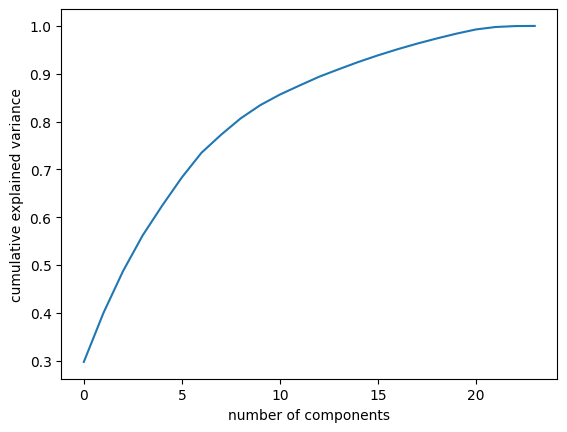

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
X = scale(features)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [14]:
# Dropping unneccesary columns
df = df.drop(['filename'],axis=1)

In [15]:
df1 = shuffle(df)

In [16]:
df1

,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
4808,0.076002,735.274158,899.637324,1237.535631,0.023741,-346.450653,235.776611,20.081324,-14.053885,16.780853,...,-6.482112,-1.622507,-1.446987,-2.928339,-6.365215,-9.793225,-12.026228,-13.366228,-12.148260,tru
2435,0.081032,1069.572936,2015.015595,1493.190456,0.019940,-352.429718,180.978409,30.520863,9.668955,17.242371,...,-0.374519,-2.097467,-4.898523,-5.063980,3.542300,18.334932,17.155987,-2.843026,-12.545064,gel
4034,0.109761,2224.974058,2481.453340,4758.505332,0.053132,-162.918869,180.988602,-58.072205,61.043930,-11.050199,...,-7.612615,-5.572572,-3.562831,-1.403184,0.328761,-2.624682,-3.325452,-4.443487,-1.212056,pia
4217,0.012672,998.094777,1585.715871,1501.421294,0.026629,-512.678406,216.376358,1.186581,-1.193522,13.213090,...,-6.903014,-14.991097,-10.635369,-7.375049,6.411600,11.081943,17.010588,8.151624,-0.843168,sax
6490,0.131303,3540.388281,3880.630539,7919.230363,0.070350,-129.822021,122.658043,-19.490177,55.988270,-15.461882,...,7.448131,-1.888943,-0.615157,0.619945,-0.504676,-1.595457,1.639103,-3.015823,-2.205513,voi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4402,0.019595,1160.462668,1523.188333,1733.713841,0.039002,-491.860687,196.638687,-14.058707,-19.660019,16.925020,...,0.699636,5.315674,11.715022,15.244774,9.546551,-0.462493,-6.697478,-10.706688,-11.948635,sax
3101,0.180024,4033.504131,4556.724860,10133.741554,0.078519,-128.321518,122.665131,8.391699,57.776688,-45.264000,...,4.708924,-5.766236,-0.522233,1.126261,-3.850566,-4.254044,-4.488180,0.965264,-9.281622,org
6428,0.135438,2760.412443,3173.463772,5483.816776,0.060873,-169.030136,130.298157,-38.958012,52.263264,8.025220,...,6.725596,-3.292483,-0.734770,-4.953449,-6.972642,-5.557561,-11.253341,-0.750419,-6.422184,voi
786,0.101007,1363.066179,1541.895007,2207.028611,0.043423,-275.825470,212.005875,-36.420868,-8.463155,14.179642,...,-7.393950,1.435760,7.288025,-0.264580,-1.145738,-5.621663,-4.708848,-2.588868,0.973623,cla


In [17]:
instru_list = df1.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(instru_list)

scaler = StandardScaler()
X = scaler.fit_transform(np.array(df1.iloc[:, :-1], dtype = float))

from joblib import dump
dump(scaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

In [18]:
y

array([ 8,  4,  6, ..., 10,  1,  6])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Supervised Algorithms

### SVM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distributions
param_dist = {'C': uniform(0.1, 20),          # Uniform distribution between 0.1 and 20
              'kernel': ['rbf'],
              'degree': randint(2, 5),          # Discrete uniform distribution between 2 and 4
              'gamma': [0.1, 1, 10, 100]}

# Create the SVC model
svc = SVC()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(svc, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", random_search.best_params_)

In [16]:
svc = SVC(kernel='rbf', C = 10.0, gamma=0.2, probability=True)

In [17]:
print(X_train[0], y_train[0])

[-0.05402212  1.42240291  1.47701749  1.57673145  0.60983464  0.47875061
 -1.13782375  0.85160902  0.50480107 -1.65140783  0.73467046 -0.45877192
  0.36912383 -0.01299193  0.26186335 -0.44370923 -0.38512583 -1.89052176
  0.20426634  0.11613384  1.5162553   0.09524059  0.15111436 -1.76668171
 -0.32326473] 2


In [18]:
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.9662118258609487

# Save the model

In [19]:
import pickle

#
# Create your model here (same as above)
#

# Save to file in the current working directory
pkl_filename = "their_tuned_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svc, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
#Ypredict = pickle_model.predict(Xtest)

Test score: 96.62 %


In [ ]:
predicted_labels = svc.predict(X_test)

In [ ]:
print("Recall: ", recall_score(y_test, predicted_labels,average=None))
print("Precision: ", precision_score(y_test, predicted_labels,average=None))
print("F1-Score: ", f1_score(y_test, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(y_test, predicted_labels,normalize=True), accuracy_score(y_test, predicted_labels,normalize=False) )

print("Number of samples:",y_test.shape[0])
print(confusion_matrix(y_test, predicted_labels))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt  
df_cm = pd.DataFrame(confusion_matrix(y_test, predicted_labels),index=["flu", "gac", "org", "pia", "tru", "voi"], columns=["flu", "gac", "org", "pia", "tru", "voi"])
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.0)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 18},fmt='g')# font size

plt.show()